In [1]:
import pandas as pd
import numpy as np

In [2]:
orig = pd.read_csv('flat_dataset.csv')

In [3]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer


def ratio_name(function_transformer, feature_names_in):
    return ["avg_room_area"]  # feature names out

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]


ratio_pipeline= make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name), StandardScaler())


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(sparse_output=False), StandardScaler())


ncat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OrdinalEncoder(), StandardScaler(with_mean=False))


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"), StandardScaler())

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

cols_to_drop = ["Санузел", "Высота потолков", "Лифт", "Материал стен", "Парковка", "price"]


qual_preprocessing = ColumnTransformer([
    ("renov_type", cat_pipeline, ["Ремонт"]),
    ('column_dropper', 'drop', cols_to_drop)
], remainder=default_num_pipeline)

In [4]:
def transform(df):
    y = pd.cut(df["price"],
                          bins=[0, 1.7e7, 2e7, 2.5e7, np.inf],
                          labels=[1, 2, 3, 4])
    df_prepared = qual_preprocessing.fit_transform(df)
    return pd.DataFrame(
        df_prepared,
        columns=[feature.split('__')[1] for feature in qual_preprocessing.get_feature_names_out()],
        index=df.index).drop(columns=['Unnamed: 0']).assign(sale_cat=y)

In [5]:
transformed_df = transform(orig)

In [140]:
transformed_df

,Ремонт_Дизайнерский,Ремонт_Евро,Ремонт_Хороший,Ремонт_Чистовая отделка,center_dist,Комнат,Площадь квартиры,Этаж,Жилая площадь,Площадь кухни,Кол-во санузлов,sale_cat
0,-0.365594,0.751161,-0.446595,-0.287876,-1.105745,-1.528668,-0.699254,-0.107723,-0.053005,-0.272567,-0.564738,3
1,-0.365594,0.751161,-0.446595,-0.287876,-0.056460,0.590873,0.193250,3.480054,0.760253,-1.442678,-0.564738,4
2,2.735276,-1.331272,-0.446595,-0.287876,-0.721500,-1.528668,-0.825803,-0.639246,-0.969533,-0.396119,-0.564738,3
3,-0.365594,0.751161,-0.446595,-0.287876,-1.105745,-1.528668,-1.048929,-0.639246,-0.053005,-0.272567,-0.564738,1
4,-0.365594,0.751161,-0.446595,-0.287876,0.061769,-0.468898,-0.259662,-0.905007,0.127719,-0.541475,-0.564738,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9978,-0.365594,-1.331272,2.239164,-0.287876,-0.499820,-0.468898,-0.542733,-0.240604,-0.388635,-0.686830,-0.564738,1
9979,2.735276,-1.331272,-0.446595,-0.287876,-0.012124,-0.468898,-0.859105,0.689561,-0.517723,-0.977541,-0.564738,2
9980,-0.365594,0.751161,-0.446595,-0.287876,1.613527,1.650643,0.952545,-1.037888,1.418604,-0.396119,1.227309,3
9981,2.735276,-1.331272,-0.446595,-0.287876,-0.056460,-1.528668,-0.925710,-1.037888,-1.679520,0.330658,-0.564738,3


<Axes: >

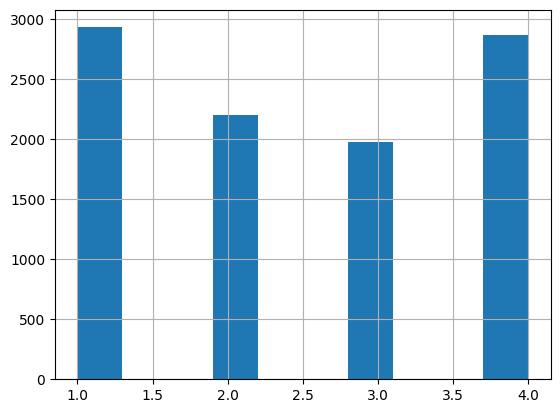

In [142]:
transformed_df.sale_cat.hist()

In [6]:
X = transformed_df.drop(['sale_cat'], axis=1)[:500]
y = transformed_df['sale_cat'][:500]

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Implementing KNN

In [10]:
from joblib import Parallel, delayed
from heapq import nsmallest
from copy import deepcopy

class KNNClassifier:
    def __init__(self, n_neighbors=5, ker='uniform', p=2, metric='minkowski', window = None):
        self.n_neighbors = n_neighbors
        self.window = window
        self.ker_func = self._get_core_function(ker)
        
        self.dist_func = self._get_metric_function(metric, p)

    @staticmethod
    def _get_metric_function(metric, p):
        if metric == 'cosine':
            return lambda x, y: 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
        elif metric == 'minkowski':
            return lambda x, y: np.power(np.sum(np.power(np.abs(np.subtract(x, y)), p)),
                                         1 / p)
        elif metric == 'chebyshev':
            return lambda x, y: np.max(np.abs(np.subtract(x, y)))
        elif metric == 'euclidean':
            return lambda x, y: np.sqrt(np.sum(np.square(np.subtract(x, y))))
        elif metric == 'manhattan':
            return lambda x, y: np.sum(np.abs(np.subtract(x, y)))
            
    @staticmethod
    def _get_core_function(ker):
        if ker == 'uniform':
            return lambda x: 1/2 * (np.abs(x) < 1)
        elif ker == 'gauss':
            return lambda x: 1/np.sqrt(2 * np.pi) * np.exp(-(x ** 2) / 2)
        elif ker == 'cosine':
            return lambda x: np.pi / 4 * np.cos(np.pi / 2 * x)
        elif ker == 'triangular':
            return lambda x: (1 - np.abs(x)) * (np.abs(x) <= 1)
        else:
            print("Unknown kernel function encountered, using uniform")
            return KNNClassifier._get_core_function('uniform')
        
        
        
    def fit(self, X, y, weights=None):
        if weights is None:
            weights = np.ones(len(X))
        self.X = X
        self.classes = np.unique(y).tolist()
        self.X_classes = [[] for _ in range(len(self.classes))]
        for x, label in zip([(x, w) for x, w in zip(X, weights)], y):
            self.X_classes[self.classes.index(label)].append(x)
        
            
    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def _count_ans(self, x, h, members, label):
        label_ans = 0
        for member, weight in members:
            label_ans += weight * self.ker_func(self.dist_func(x, member) / h)
        return (label_ans, label)
        
        
        
    def _predict_single(self, x):
        ans = None
        y = None
        h = self._get_window(x)
        for members, label in zip(self.X_classes, self.classes):
            cur_ans = 0
            for member, weight in members:
                cur_ans += weight * self.ker_func(self.dist_func(x, member) / h)
            if ans is None or cur_ans > ans:
                ans = cur_ans
                y = label
        return y

    def _get_window(self, x):
        if self.window is not None:
            return self.window
        else:
            neighbors = self._get_sorted_neighbors(x, self.n_neighbors + 1)
            if len(neighbors) < self.n_neighbors + 1:
                print("k is bigger than number of training points")
            return self.dist_func(x, neighbors[self.n_neighbors])

    def _get_sorted_neighbors(self, ref, k):
        dist_key = lambda x: self.dist_func(x, ref)
        return nsmallest(k, self.X, key=dist_key)


In [14]:
from sklearn.metrics import f1_score

clf = KNeighborsClassifier(n_neighbors=10, algorithm='brute')
clf.fit(X_train.values, y_train.values)
y_pred = clf.predict(X_test.values)
print(f1_score(y_test, y_pred, average='weighted'))

0.722191343681259


In [15]:
my_clf = KNNClassifier(n_neighbors=10)
my_clf.fit(X_train.values, y_train.values)
my_y_pred = my_clf.predict(X_test.values)
print(f1_score(y_test, my_y_pred, average='weighted'))

0.722191343681259


# Finding the best hyperparameters

In [113]:
import optuna

def create_classifier_window(trial):
    metric = trial.suggest_categorical('metric', ['cosine', 'minkowski', 'chebyshev', 'euclidean', 'manhattan'])
    ker = trial.suggest_categorical('ker', ['uniform', 'gauss', 'cosine', 'triangular'])
    window = trial.suggest_float('window', 1e-3, 100)    

    clf = KNNClassifier(ker=ker, metric=metric, window=window)
    
    return clf

def create_classifier_k(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 15)
    metric = trial.suggest_categorical('metric', ['cosine', 'minkowski', 'chebyshev', 'euclidean', 'manhattan'])
    ker = trial.suggest_categorical('ker', ['uniform', 'gauss', 'cosine', 'triangular'])

    clf = KNNClassifier(n_neighbors, ker=ker, metric=metric, window=None)
    
    return clf

def create_sklearn_clf(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 15)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['cosine', 'l1', 'l2', 'manhattan'])

    clf = KNeighborsClassifier(n_neighbors, weights=weights, metric=metric)
    
    return clf

def objective_window(trial):
    my_clf = create_classifier_window(trial)
    my_clf.fit(X_train.values, y_train.values)
    my_y_pred = my_clf.predict(X_val.values)
    score = f1_score(y_val, my_y_pred, average='weighted')
    return score

def objective_k(trial):
    my_clf = create_classifier_k(trial)
    my_clf.fit(X_train.values, y_train.values)
    my_y_pred = my_clf.predict(X_val.values)
    score = f1_score(y_val, my_y_pred, average='weighted')
    return score

def objective_sklearn(trial):
    clf = create_sklearn_clf(trial)
    clf.fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_val.values)
    score = f1_score(y_val, y_pred, average='weighted')
    return score

In [114]:
optuna.logging.set_verbosity(optuna.logging.WARN)

study = optuna.create_study(direction='maximize')
study.optimize(objective_window, n_trials=300, n_jobs=-1)
best_window_params = study.best_params
best_window_value = study.best_value
study.best_params, study.best_value

({'metric': 'minkowski', 'ker': 'triangular', 'window': 2.3614178603781566},
 0.6570095117489799)

In [115]:
optuna.logging.set_verbosity(optuna.logging.WARN)

study = optuna.create_study(direction='maximize')
study.optimize(objective_k, n_trials=300, n_jobs=-1)
best_k_params = study.best_params
best_k_value = study.best_value
study.best_params, study.best_value

({'n_neighbors': 3, 'metric': 'cosine', 'ker': 'triangular'},
 0.7224285714285713)

In [116]:
optuna.logging.set_verbosity(optuna.logging.WARN)

study = optuna.create_study(direction='maximize')
study.optimize(objective_sklearn, n_trials = 1000, n_jobs=-1)
best_sklearn_params = study.best_params
best_sklearn_value = study.best_value
study.best_params, study.best_value

({'n_neighbors': 6, 'weights': 'distance', 'metric': 'l1'}, 0.7254996485561918)

In [150]:
from copy import copy

def get_cls_stats(CLS, best_params, X_pred, y_pred):
    neighbors = []
    scores = []
    best_params = copy(best_params)
    best_params.pop('n_neighbors', None)
    for n in range(1, 16):
        sk_cls = CLS(n_neighbors=n, **best_params)
        sk_cls.fit(X_train.values, y_train.values)
        preds = sk_cls.predict(X_pred.values)
        score = f1_score(y_pred, preds, average='weighted')
        neighbors.append(n)
        scores.append(score)
    return (neighbors, scores)

In [151]:
import matplotlib.pyplot as plt

def plot_from_neighbors(neighbors, scores, cls):
    fig, ax = plt.subplots()
    ax.scatter(neighbors, scores)
    
    ax.set(xlabel='number of neighbors', ylabel='f1 score', title = f'Graph for classifier {cls}')
    ax.grid()
    plt.xticks(neighbors)
    
    plt.show()

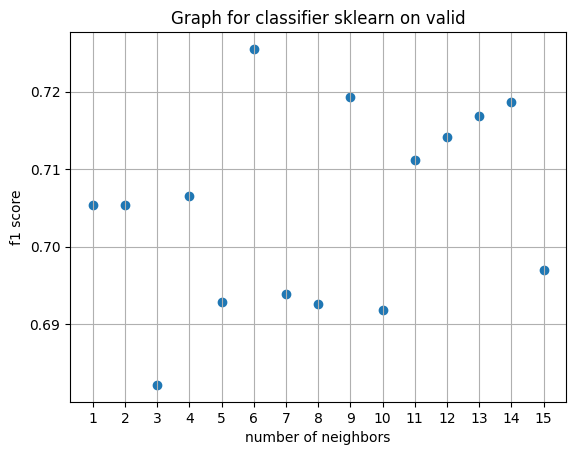

In [152]:
neighbors, scores = get_cls_stats(KNeighborsClassifier, best_sklearn_params, X_val, y_val)
plot_from_neighbors(neighbors, scores, 'sklearn on valid')

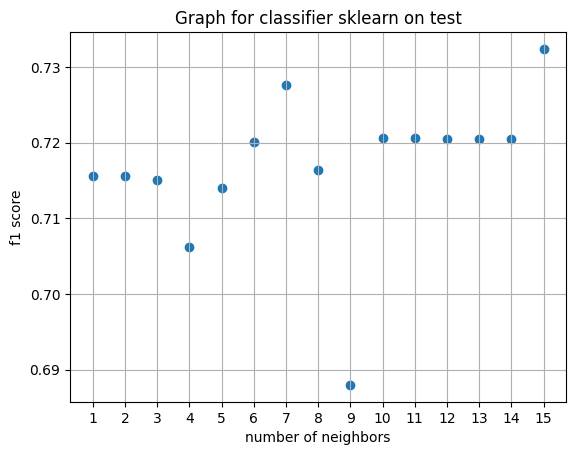

In [153]:
neighbors, scores = get_cls_stats(KNeighborsClassifier, best_sklearn_params, X_test, y_test)
plot_from_neighbors(neighbors, scores, 'sklearn on test')

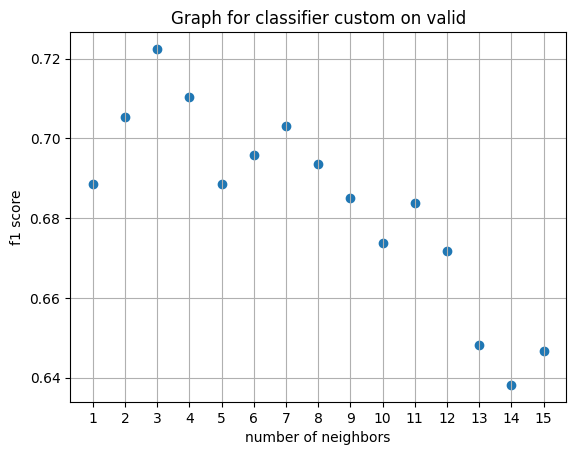

In [154]:
neighbors, scores = get_cls_stats(KNNClassifier, best_k_params, X_val, y_val)
plot_from_neighbors(neighbors, scores, 'custom on valid')

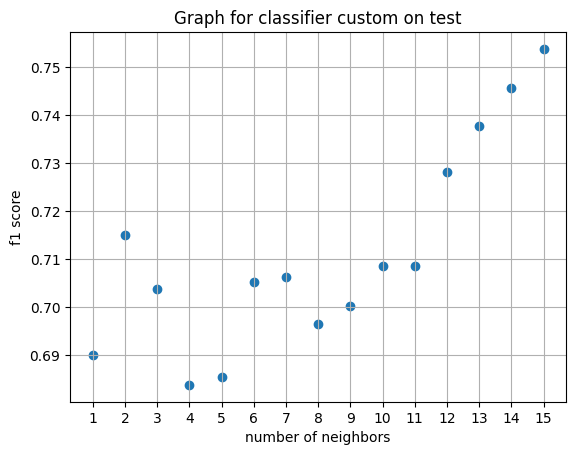

In [155]:
neighbors, scores = get_cls_stats(KNNClassifier, best_k_params, X_test, y_test)
plot_from_neighbors(neighbors, scores, 'custom on test')

# LOWESS

In [126]:
from tqdm import tqdm

weights = np.ones(len(X_train))
epochs = 3
for epoch in range(epochs):
    for i in tqdm(range(len(weights))):
        cls = KNNClassifier(ker='gauss')
        cls.fit(np.delete(X_train.values, i), np.delete(y_train.values, i), weights)
        y_pred = cls._predict_single(X_train.values[i])
        weights[i] = cls.ker_func(y_train.values[i] != y_pred)

100%|██████████| 300/300 [00:15<00:00, 19.52it/s]


In [42]:
weights[:5]

array([0.24197072, 0.39894228, 0.24197072, 0.24197072, 0.39894228])

In [135]:
best_cls = KNNClassifier(**best_k_params)
best_cls.fit(X_train.values, y_train.values, weights)
preds = best_cls.predict(X_test.values)
score = f1_score(y_test, preds, average='weighted')
f'score before is {best_k_value:.3f}, score after is {score:.3f}'

'score before is 0.722, score after is 0.697'

In [136]:
def get_resampled_data(X,y, weights):
    X_new = []
    y_new = []
    for i, (x, y) in enumerate(zip(X, y)):
        weight = weights[i]
        times = int(weight * 100 // 1)
        X_new.extend(x for _ in range(times))
        y_new.extend(y for _ in range(times))

    return np.array(X_new), np.array(y_new)

In [166]:
n_neighb = best_sklearn_params['n_neighbors']
best_params_copy = copy(best_sklearn_params)
best_params_copy.pop('n_neighbors' , None)

sk_cls = KNeighborsClassifier(n_neighbors = n_neighb * 25, **best_params_copy)
sk_x, sk_y = get_resampled_data(X_train.values, y_train.values, weights)
sk_cls.fit(sk_x, sk_y)
sk_preds = sk_cls.predict(X_test.values)

sk_score = f1_score(y_test, sk_preds, average='weighted')
f'score before is {best_sklearn_value:.3f}, score after is {sk_score:.3f}'

'score before is 0.725, score after is 0.706'